In [1]:
import scanpy as sc
from sklearn.metrics.pairwise import euclidean_distances
import numpy as np

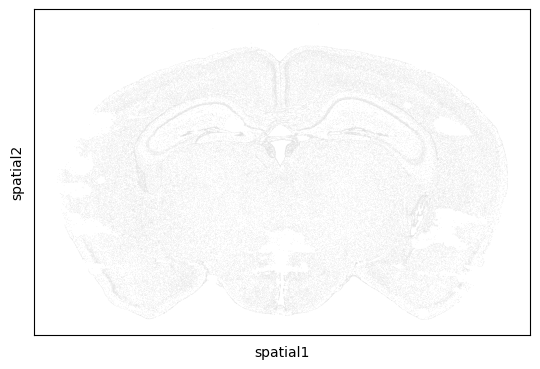

In [2]:
ad = sc.read('../MERFISH_BICCN/UCE_outputs/sec_37_raw_uce_adata.h5ad')
sc.pl.spatial(ad, spot_size=0.01)

In [3]:
ad

AnnData object with n_obs × n_vars = 90143 × 486
    obs: 'brain_section_label', 'cell_label', 'brain_section_labelr', 'cluster_alias', 'average_correlation_score', 'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex', 'x_section', 'y_section', 'z_section', 'neurotransmitter', 'class', 'subclass', 'supertype', 'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color', 'supertype_color', 'cluster_color', 'x_reconstructed', 'y_reconstructed', 'z_reconstructed', 'parcellation_index', 'x_ccf', 'y_ccf', 'z_ccf', 'parcellation_organ', 'parcellation_category', 'parcellation_division', 'parcellation_structure', 'parcellation_substructure', 'parcellation_organ_color', 'parcellation_category_color', 'parcellation_division_color', 'parcellation_structure_color', 'parcellation_substructure_color', 'n_genes'
    var: 'gene_symbol', 'transcript_identifier', 'n_cells'
    uns: 'accessed_on', 'class_color_colors', 'class_colors', 'parcellation_structure_colors', 'src'
    ob

# Majority neighbor class in neighborhood task

In [5]:
def get_neighbors(ad, ad_cell, radius=0.1):
    dists = np.asarray(euclidean_distances(ad.obsm['spatial'], ad_cell.obsm['spatial']))
    return ad[dists.reshape(dists.shape[0],) < radius].copy()

def get_neighbor_cell_type_vector(all_ct, neighbor_ct):
    sum_counts = neighbor_ct.sum()
    ratios = []
    for ct in all_ct:
        if ct in neighbor_ct:
            ratios.append(neighbor_ct[ct] / sum_counts)
        else:
            ratios.append(0.0)
    return ratios
            h
def find_neighborhood_cell_type(ad, ad_cell, radius=0.1, cell_type_key='class'):
    all_cell_types = ad.obs[cell_type_key].unique()
    neighbors = get_neighbors(ad, ad_cell, radius)
    neighbor_cell_types = neighbors.obs[cell_type_key].value_counts()
    neighbor_vect = get_neighbor_cell_type_vector(all_cell_types, neighbor_cell_types)
    return neighbor_cell_types.index[0], len(neighbors), neighbor_vect

majority_cell_types = []
densities = []
cell_type_vectors = []
for cell in ad.obs_names:
    ct, num_neighbors, ct_vector = find_neighborhood_cell_type(ad, ad[cell], radius=0.05)
    majority_cell_types.append(ct)
    densities.append(num_neighbors)
    cell_type_vectors.append(ct_vector)
ad.obs['majority_neighbor_class'] = majority_cell_types
ad.obs['neighbor_density'] = densities
ad.obs['neighborhood_class_proportions'] = cell_type_vectors

In [12]:
string_cell_type_vectors = [','.join(np.asarray(ctvect).astype('str')) for ctvect in cell_type_vectors]
ad.obs['neighborhood_class_proportions'] = string_cell_type_vectors

In [13]:
ad.write('spatial_dataset.h5ad')

In [14]:
ad = sc.read('spatial_dataset.h5ad')

In [15]:
ad.obs = ad.obs.loc[:,['majority_neighbor_class','neighbor_density','neighborhood_class_proportions']]

In [16]:
del ad.obsm['X_uce']
del ad.uns['accessed_on']
del ad.uns['class_color_colors']
del ad.uns['class_colors']
del ad.uns['parcellation_structure_colors']
del ad.uns['src']

In [17]:
ad.var = ad.var.drop(columns=['transcript_identifier','n_cells'])

In [18]:
ad.write('spatial_dataset_minimal.h5ad')